In [1]:
import os
import numpy as np
import torch


C:\Users\lenovo\.conda\envs\CLMLF\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lenovo\.conda\envs\CLMLF\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\lenovo\.conda\envs\CLMLF\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from models.VQVAE import VQVAE

# 测试VAQAE模型

In [15]:
batch_size = 128
embedding_dim = 16
num_embeddings = 128
transform=transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.MNIST('/data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('/data', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

# compute the variance of the whole training set to normalise the Mean Squared Error below.
train_images = []
for images, labels in train_loader:
    train_images.append(images)
train_images = torch.cat(train_images, dim=0)




In [16]:
train_images.size()

torch.Size([60000, 1, 28, 28])

In [17]:

train_data_variance = torch.var(train_images)


In [18]:
train_data_variance

tensor(0.0949)

In [19]:
model = VQVAE(1, embedding_dim, num_embeddings, train_data_variance)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
# train VQ-VAE
epochs = 5
print_freq = 500

for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = images - 0.5 # normalize to [-0.5, 0.5]
        images = images.cuda()
        loss = model(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0


KeyboardInterrupt: 

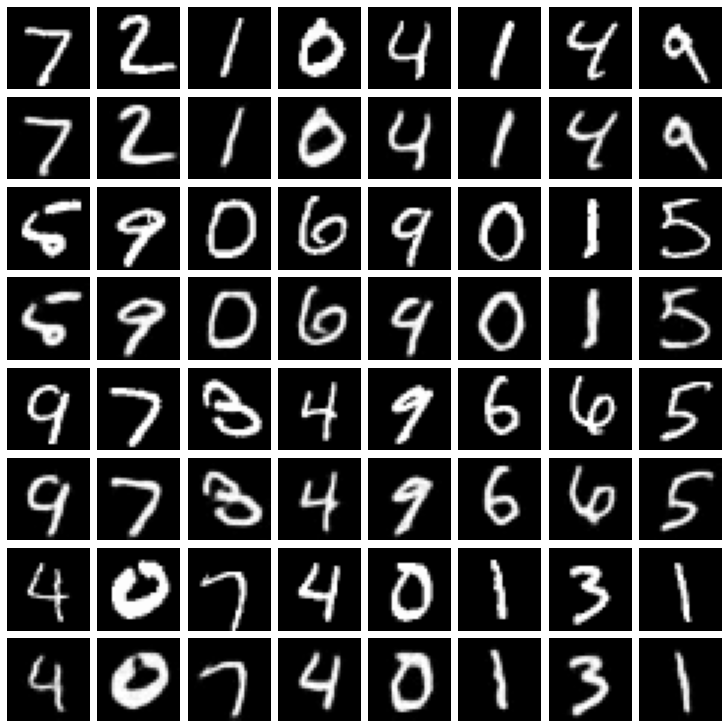

In [10]:
# reconstructe images

test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)

n_samples = 32
images = images[:n_samples]

model.eval()

norm_images = (images - 0.5).cuda()
with torch.no_grad():
    e, recon_images = model(norm_images)

recon_images = np.array(np.clip((recon_images + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
ori_images = np.array(images.numpy() * 255, dtype=np.uint8)

recon_images = recon_images.reshape(4, 8, 28, 28)
ori_images = ori_images.reshape(4, 8, 28, 28)

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row * 2, n_col])
        f_ax.imshow(ori_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")
        f_ax = fig.add_subplot(gs[n_row * 2 + 1, n_col])
        f_ax.imshow(recon_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")